In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [4]:
spd_data = np.load("/Users/dongtianchi/Documents/GIT/SpectralReconstruction/ComputationalSpectrometers/NNLS/cleandata.npy", allow_pickle= True)

In [5]:

# Step 1: Perform clustering on spd_data
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(spd_data.T)

/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
# Step 2: Split data into clusters
clustered_data = [spd_data[:, labels == i] for i in range(n_clusters)]


In [8]:
class SPDRePCA:
    def __init__(self, spd_data, n_components, wavelengths, mu, sigma):
        self.data = spd_data
        self.n_components = n_components
        self._pca = PCA(n_components=self.n_components)
        self.wavelengths = wavelengths
        self.mu = mu
        self.sigma = sigma

    def Reconstructed_spectrum(self):
        self.scores = self._pca.fit_transform(self.data)
        self.filters = np.zeros((len(self.mu), len(self.wavelengths)))
        for i in range(8):
            self.filters[i] = np.exp(-0.5 * ((self.wavelengths - self.mu[i]) / self.sigma[i])**2)
        self.M = np.dot(self.filters, self.scores)
        self.response_matrix = np.dot(self.filters, self.data)
        self.mean_response = np.mean(self.response_matrix, axis=1)
        self.mean_response = self.mean_response.reshape(-1, 1)
        self.M_inv = np.linalg.inv(self.M)
        response_diff = self.response_matrix - self.mean_response
        self.a_hat = np.dot(self.M_inv, response_diff)
        mean_spd = np.mean(self.data, axis=1)
        self.reconstructed_spectrum = np.dot(self.scores, self.a_hat) + mean_spd[:, np.newaxis]
        return self.reconstructed_spectrum , self.scores, self.a_hat

In [9]:
# Step 3: Apply SPDRePCA class to each cluster
wavelengths = np.arange(360, 831)
mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])

reconstructed_clusters = []
for cluster in clustered_data:
    rpca = SPDRePCA(cluster, n_components=8, wavelengths=wavelengths, mu=mu, sigma=sigma)
    reconstructed_spectrum, scores, a_hat = rpca.Reconstructed_spectrum()
    reconstructed_clusters.append(reconstructed_spectrum)



In [10]:
# Step 4: Reorder reconstructed spectra based on clustering labels
reconstructed_data = np.zeros_like(spd_data)
for i, label in enumerate(labels):
    cluster_idx = np.where(labels == label)[0]
    local_idx = np.where(cluster_idx == i)[0][0]
    reconstructed_data[:, i] = reconstructed_clusters[label][:, local_idx]

# Now reconstructed_data has the reconstructed spectra in the same order as the original spd_data

In [14]:
def Plot(spd, Rspd):
    # 创建一个包含三个子图的图像
    fig, axs = plt.subplots(3, 1)
    s = spd
    r = Rspd

    # 绘制真实光谱图
    axs[0].plot(wavelengths, s, label='True Spectrum')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Intensity')
    axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
    axs[0].legend()

    # 绘制重建光谱图
    axs[1].plot(wavelengths, r, label='Reconstructed Spectrum')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

    # 绘制重建光谱和真实光谱叠加的图
    axs[2].plot(wavelengths, s, label='True Spectrum')
    axs[2].plot(wavelengths, r, label='Reconstructed Spectrum')
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('Intensity')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

def Evaluate(spd, Rspd):
    s = spd
    s_re = Rspd
    MAE = np.mean(np.absolute(s - s_re))
    RMSE = np.sqrt(np.mean(np.square(s- s_re)))
    RRMSE = RMSE / np.mean(s_re)

    #GFC
    num = abs(np.sum(s * s_re))
    denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
    denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
    GFC =num / (denom_s * denom_s_re)

    print("MAE: ", MAE)
    print("RMSE: ", RMSE)
    print("RRMES: ", RRMSE)
    print("GFC: ", GFC)

In [15]:
reconstructed_data.shape

(471, 1494)

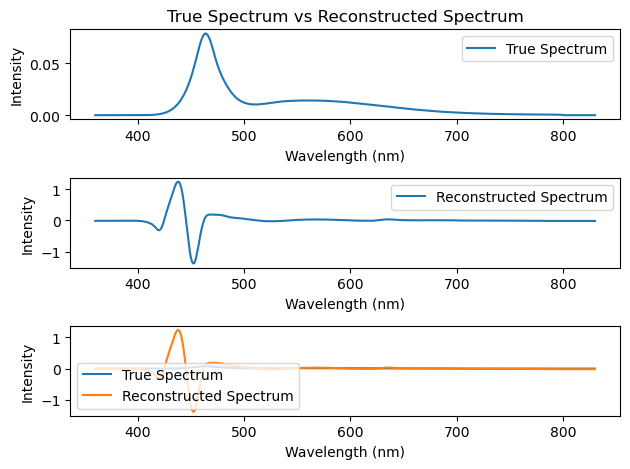

In [18]:
Rs3 = reconstructed_data[:,-1]
s3 = spd_data[:,-1]
Plot(s3, Rs3)

In [19]:
Evaluate(s3, Rs3)

MAE:  0.08633729496307675
RMSE:  0.2561207664599379
RRMES:  37.296639809353984
GFC:  0.11687309009451745
